<a href="https://colab.research.google.com/github/Leomutz/NIDS1/blob/main/2024_31october_nsl_kdd_cnn_imagesv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install tab2img

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv1D, MaxPool1D, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler


from tab2img.converter import Tab2Img

In [65]:
# load the dataset
df_train = pd.read_csv('/content/NIDS-datasets/KDDTrain+.txt', header=None)
df_test = pd.read_csv('/content/NIDS-datasets/KDDTest+.txt', header=None)

In [66]:
# check the shape of the dataset
print(df_train.shape, df_test.shape)

(125973, 43) (22544, 43)


In [67]:
# merging the dataset
df = pd.concat([df_train, df_test])

# check the shape
print(df.shape)

(148517, 43)


In [68]:
# add columns in the dataset
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_byte','land','wrong_fragment',
                    'urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
                    'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_logins',
                    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
                    'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
            'dst_host_same_srv_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
        'dst_host_rerror_rate','dst_host_srv_rerror_rate','class','difficulty_level']


In [69]:
# check the column names by accessing the dataframe
print(df.head())

   duration protocol_type   service flag  src_bytes  dst_byte  land  \
0         0           tcp  ftp_data   SF        491         0     0   
1         0           udp     other   SF        146         0     0   
2         0           tcp   private   S0          0         0     0   
3         0           tcp      http   SF        232      8153     0   
4         0           tcp      http   SF        199       420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_srv_port_rate  \
0                    0.03                         0.17   
1                    0.60                         0.88   
2                   

In [70]:
# identify the missing values
df.isnull().values.any()

False

In [71]:
# select categorical variables
df_cat = df.select_dtypes('object')
df_cat.head()

,protocol_type,service,flag,class
0,tcp,ftp_data,SF,normal
1,udp,other,SF,normal
2,tcp,private,S0,neptune
3,tcp,http,SF,normal
4,tcp,http,SF,normal


In [72]:
# list of categorical columns without the label
cols_list = ['protocol_type', 'service', 'flag']
cols_list

['protocol_type', 'service', 'flag']

In [73]:
# one-hot encoding function
def one_hot_encode(data, col):
  for i in col:
    dummies = pd.get_dummies(data[i], prefix=i, drop_first=False, dtype='int')
    data = pd.concat([data, dummies], axis=1)
    data = data.drop(columns=[i])
  return data

In [74]:
#perform one hot encoding
df_onehot = one_hot_encode(df, cols_list)
print(df_onehot.shape)

(148517, 124)


In [75]:
df_onehot['class']

,class
0,normal
1,normal
2,neptune
3,normal
4,normal
...,...
22539,normal
22540,normal
22541,back
22542,normal


In [76]:
#copy data from the original
df_data = df_onehot.copy()
df_data.shape

(148517, 124)

In [77]:
#fixing labels on the column 'class'

classlist = []
attack1 = ("apache2","back","land","neptune","mailbomb","pod","processtable","smurf","teardrop","udpstorm","worm")
attack2 = ("ipsweep","mscan","nmap","portsweep","saint","satan")
attack3 = ("buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack","xterm")
attack4 = ("ftp_write","guess_passwd","httptunnel","imap","multihop","named","phf","sendmail","Snmpgetattack","spy","snmpguess","warezclient","warezmaster","xlock","xsnoop")

# initialize the count of each attack category
DoS = 0
Probe = 0
U2R = 0
R2L = 0
Normal = 0

for i in df_data['class']:
  if i in attack1:
    classlist.append('DoS')
    DoS += 1
  elif i in attack2:
    classlist.append('Probe')
    Probe += 1
  elif i in attack3:
    classlist.append('U2R')
    U2R += 1
  elif i in attack4:
    classlist.append('R2L')
    R2L += 1
  else:
    classlist.append('Normal')
    Normal += 1

print('Number of attacks in groups:\n')
print('DoS:{}, Probe:{}, U2R:{}, R2L:{}, Normal:{}'.format(DoS, Probe, U2R, R2L, Normal))

Number of attacks in groups:

DoS:53387, Probe:14077, U2R:119, R2L:3702, Normal:77232


In [78]:
#view the class list
classlist[:10]

['Normal',
 'Normal',
 'DoS',
 'Normal',
 'Normal',
 'DoS',
 'DoS',
 'DoS',
 'DoS',
 'DoS']

In [79]:
# now append the class column to the dataFrame
df_data['class'] = classlist
df_data.head()

,duration,src_bytes,dst_byte,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [80]:
#verify categorical variables
#only the label class
df_data.select_dtypes('object').head()

,class
0,Normal
1,Normal
2,DoS
3,Normal
4,Normal


In [81]:
#separate labels from the dataset
y = df_data.pop('class')

# the remaining data will be X
X = df_data
print(X.shape, y.shape)

(148517, 123) (148517,)


In [82]:
# encoding labels function

# binary classification (0 for normal and 1 for attack)
def attack_encode_bin(attack):
  if attack == 'Normal':
    return 0
  else:
    return 1

# multi-class classification
# multi-labels (0,1,2,3,4)
def attack_encode_mult(attack):
  if attack == 'Normal':
    return 0
  elif attack == 'DoS':
    return 1
  elif attack == 'Probe':
    return 2
  elif attack == 'U2R':
    return 3
  else:
    return 4

In [83]:
# binary classification labels
y_bin = y.apply(attack_encode_bin)
print(y_bin.unique())

[0 1]


In [84]:
X.head()

,duration,src_bytes,dst_byte,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [85]:
X[0:1][0:1]

,duration,src_bytes,dst_byte,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [86]:
type(X.values), type(y_bin.values)

(numpy.ndarray, numpy.ndarray)

In [87]:
# convert dataset into images
model_nsl = Tab2Img()
images = model_nsl.fit_transform(X.values, y_bin.values)

In [88]:
images.shape

(148517, 12, 12)

In [90]:
images[0:2]

array([[[0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [2.00e+00, 0.00e+00, 0.00e+00, 5.00e-02, 0.00e+00, 0.00e+00,
         0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 1.70e-01, 1.00e+00, 2.00e+01, 3.00e-02, 0.00e+00,
         0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 1.70e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00

In [91]:
images.size, images.ndim

(21386448, 3)

In [92]:
y_bin.values[1]

0

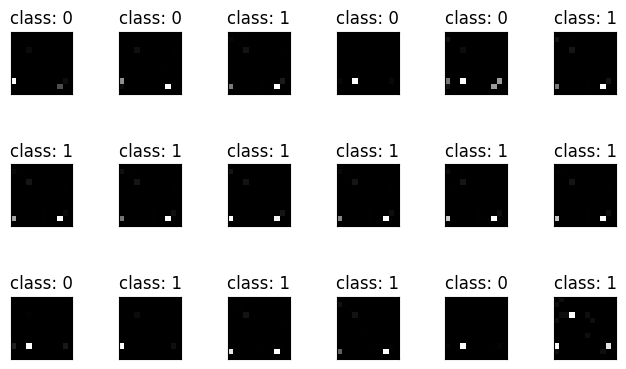

In [93]:
# Visualize the dataset
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.tight_layout()
    plt.imshow(images[i], cmap='gray', interpolation='none')
    plt.title('class: {}'.format(y_bin.values[i]))
    plt.yticks([])
    plt.xticks([])

In [94]:
# multi-class classification labels
y_mult = y.apply(attack_encode_mult)
print(y_mult.unique())

[0 1 4 2 3]


In [95]:
# binarize labels for multi-class
y_mult = LabelBinarizer().fit_transform(y_mult)
print(y_mult[:3])

[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]]


In [126]:
# binary classification
X_train,X_test, y_train,y_test = train_test_split(images, y_bin, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(118813, 12, 12) (29704, 12, 12)
(118813,) (29704,)


In [127]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2], 1)

In [128]:
# more reshaping
X_train = X_train/255
X_test = X_test/255

In [129]:
print(X_train.shape, X_test.shape)

(118813, 12, 12, 1) (29704, 12, 12, 1)


In [130]:
y_test.values[0:5]

array([0, 0, 0, 0, 1])

In [131]:
# binary class classification
model_bin = Sequential()
model_bin.add(Conv2D(32,3,padding='same', input_shape=(12,12,1),activation='relu'))
#model_bin.add(MaxPool1D(pool_size=(4)))
#model_bin.add(Dropout(0.2))

model_bin.add(Conv2D(64,3,padding='same',activation='relu'))
model_bin.add(MaxPool2D(pool_size=(4)))
model_bin.add(Dropout(0.25))

#model_bin.add(Conv1D(32,3,padding='same',activation='relu'))
#model_bin.add(MaxPool1D(pool_size=(4)))
#model_bin.add(Dropout(0.2))

model_bin.add(Flatten())
model_bin.add(Dense(128, activation='relu'))
model_bin.add(Dropout(0.5))
model_bin.add(Dense(units=1, activation='sigmoid'))

optimizer_bin = keras.optimizers.Adam(learning_rate=0.001)
model_bin.compile(loss='binary_crossentropy', optimizer=optimizer_bin,
                  metrics=['accuracy'])

model_bin.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,801 (362.50 KB)

 Trainable params: 92,801 (362.50 KB)

 Non-trainable params: 0 (0.00 B)

In [148]:
# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [133]:
# training the model
history = model_bin.fit(X_train, y_train, epochs=150,
                        batch_size=5000, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.6646 - loss: 3.3017 - val_accuracy: 0.8052 - val_loss: 11.9326
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7889 - loss: 2.9673 - val_accuracy: 0.8586 - val_loss: 1.7197
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8063 - loss: 1.9578 - val_accuracy: 0.8706 - val_loss: 2.4205
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8521 - loss: 1.3705 - val_accuracy: 0.8759 - val_loss: 1.2917
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8667 - loss: 2.9590 - val_accuracy: 0.8712 - val_loss: 1.6179
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8686 - loss: 2.2623 - val_accuracy: 0.8889 - val_loss: 1.9206
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8810 - loss: 1.4651 - val_accuracy: 0.8855 - val_loss: 7.8174
Epoch 8/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8827 - loss: 2.1796 - val_accuracy: 

In [134]:
# predicting target on the test data
test_pred = model_bin.evaluate(X_test, y_test, verbose=1)
print(f'Test prediction\n Loss: {test_pred[0]}\n Accuracy: {test_pred[1]*100}%')

929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9704 - loss: 0.1191
Test prediction
 Loss: 0.1213320940732956
 Accuracy: 97.08120226860046%


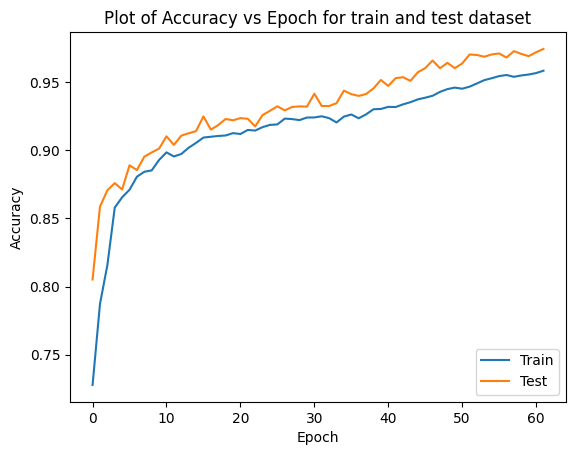

In [135]:
# plot of accuracy vs epoch for train and test dataset

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Plot of Accuracy vs Epoch for train and test dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('/content/Results/plot_accuracy_epoch_binary.eps')
plt.show()

In [136]:
# predict on the test dataset
y_pred = model_bin.predict(X_test, batch_size=500)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [137]:
# view the classification report on the test dataset
class_names = ['Normal', 'Attack']
y_pred = np.round(y_pred)
print('Classification Report on Test data\n',
      classification_report(y_test, y_pred, target_names=class_names))

Classification Report on Test data
               precision    recall  f1-score   support

      Normal       0.98      0.97      0.97     15486
      Attack       0.96      0.98      0.97     14218

    accuracy                           0.97     29704
   macro avg       0.97      0.97      0.97     29704
weighted avg       0.97      0.97      0.97     29704



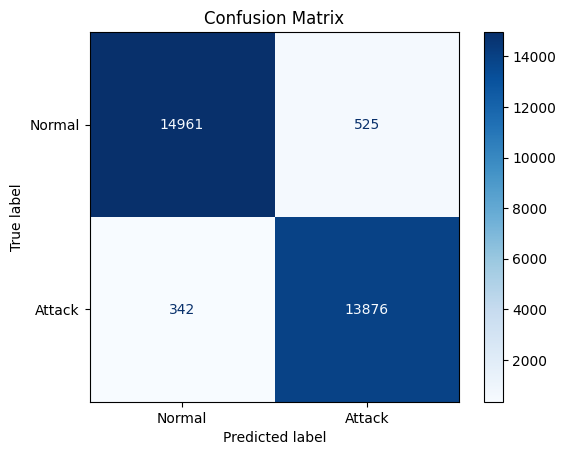

In [138]:
# view the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cm_fig.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('/content/Results/confusion_matrix_binary.eps')
plt.show()

In [139]:
# multi-class classification
X_train,X_test, y_train,y_test = train_test_split(images, y_mult, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(103961, 12, 12) (44556, 12, 12)
(103961, 5) (44556, 5)


In [140]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2], 1)

In [141]:
# reshaping
X_train = X_train/255
X_test = X_test/255

In [142]:
# multi-class classification

model_mult = Sequential()
model_mult.add(Conv2D(32,3,padding='same', input_shape=(12,12,1),activation='relu'))

model_mult.add(Conv2D(64,3,padding='same',activation='relu'))
model_mult.add(MaxPool2D(pool_size=(4)))
model_mult.add(Dropout(0.25))

model_mult.add(Flatten())
model_mult.add(Dense(128, activation='relu'))
model_mult.add(Dropout(0.5))
model_mult.add(Dense(units=5, activation='softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_mult.compile(loss='categorical_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])

model_mult.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,317 (364.52 KB)

 Trainable params: 93,317 (364.52 KB)

 Non-trainable params: 0 (0.00 B)

In [225]:
# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [226]:
# training the model
history = model_mult.fit(X_train, y_train, epochs=150, batch_size=5000,
                         validation_split=0.2, callbacks=[early_stopping])

Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9251 - loss: 0.2271 - val_accuracy: 0.9474 - val_loss: 0.1758
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9255 - loss: 0.2340 - val_accuracy: 0.9472 - val_loss: 0.1916
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9257 - loss: 0.2888 - val_accuracy: 0.9484 - val_loss: 0.1854
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9250 - loss: 0.3159 - val_accuracy: 0.9487 - val_loss: 0.1868
Epoch 5/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9280 - loss: 0.2335 - val_accuracy: 0.9512 - val_loss: 0.1768
Epoch 6/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9273 - loss: 0.2784 - val_accuracy: 0.9500 - val_loss: 0.1680
Epoch 7/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9280 - loss: 0.2280 - val_accuracy: 0.9500 - val_loss: 0.1621
Epoch 8/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9272 - loss: 0.2489 - val_accuracy: 0.

In [227]:
# predicting target on test data
test_pred = model_mult.evaluate(X_test, y_test, verbose=1)
print(f'Test results\n Loss: {test_pred[0]}\n Accuracy: {test_pred[1]*100}%')

1393/1393 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9561 - loss: 0.1261
Test results
 Loss: 0.12690553069114685
 Accuracy: 95.66388130187988%


In [228]:
# on test dataset
y_pred = model_mult.predict(X_test, batch_size=500)

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [229]:
# print the classification report on the test data

class_names = ['Normal', 'DoS','Probe','U2R','R2L']
#y_rounded_pred = np.round(y_pred) # or using np.argmax()
#y_pred_labels = [np.argmax(i) for i in y_pred]
#y_pred_labels[:5]

y_rounded_pred = np.round(y_pred)
print("Classification Report on Test data\n",
     classification_report(y_test, y_rounded_pred, target_names=class_names))

Classification Report on Test data
               precision    recall  f1-score   support

      Normal       0.99      0.97      0.98     23153
         DoS       0.96      0.97      0.97     16081
       Probe       0.92      0.81      0.86      4144
         U2R       0.00      0.00      0.00        32
         R2L       0.80      0.39      0.52      1146

   micro avg       0.97      0.94      0.96     44556
   macro avg       0.73      0.63      0.67     44556
weighted avg       0.97      0.94      0.95     44556
 samples avg       0.94      0.94      0.94     44556



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


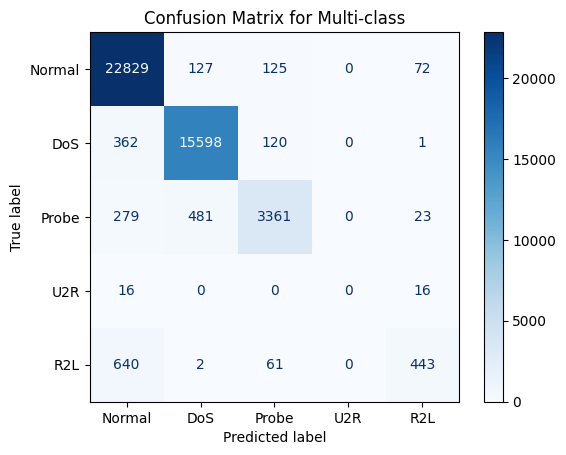

In [230]:
# view the confusion matrix for multi-class classification
cm = confusion_matrix(y_test.argmax(axis=1), y_rounded_pred.argmax(axis=1))

cm_fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cm_fig.plot(cmap=plt.cm.Blues,)
#ConfusionMatrixDisplay.from_estimator(model_mult, y_test.argmax(axis=1), y_rounded_pred.argmax(axis=1),values_format='d', cmap='Blues')
plt.title('Confusion Matrix for Multi-class')

plt.savefig('/content/Results/confusion_matrix_multi-class.eps')
plt.show()


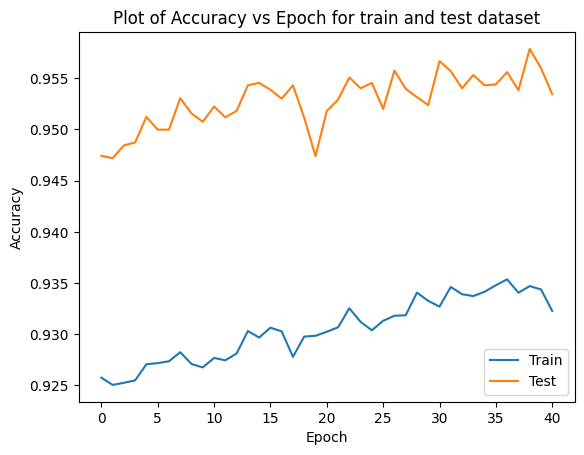

In [231]:
# plot of accuracy vs epoch for train and test dataset

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Plot of Accuracy vs Epoch for train and test dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('/content/Results/plot_accuracy_epoch_multiclass.eps')
plt.show()

In [58]:
# saving the model (binary)

# serialize the model to JSON
model_bin_cnnv1_json = model_bin.to_json()
with open('/content/Results/model_bin_cnnv1.json', 'w') as json_file:
  json_file.write(model_bin_cnnv1_json)

# serialize weights to HDF5
model_bin.save_weights('/content/Results/model_bin_cnnv1.weights.h5')
print('Saved model to disk')

Saved model to disk


In [59]:
# saving the model (multi-class)

# serialize the model to JSON
model_mult_cnnv1_json = model_mult.to_json()
with open('/content/Results/model_mult_cnnv1.json', 'w') as json_file:
  json_file.write(model_mult_cnnv1_json)

# serialize weights to HDF5
model_mult.save_weights('/content/Results/model_mult_cnnv1.weights.h5')